In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib  # pip install pathlib
import geopandas as gpd

In [9]:
# load in readmissions
DATA_PATH = pathlib.Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")
F_NAME = "readmissions.csv"
readmissions_df = pd.read_csv(DATA_PATH / F_NAME)

# load in shapefile
SHAPEFILE_PATH = "shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
states_gdf = gpd.read_file(DATA_PATH.joinpath(SHAPEFILE_PATH))

Looks liek the merge column is `STUSPS` and the `geometry` column will be used for plotting.

In [10]:
states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


Lets see what the map object looks like using the native plotting of the GeoPandas df.

<Axes: >

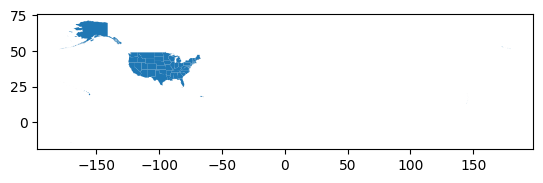

In [11]:
states_gdf.plot()

Okay it looks like this includes all US territories so we might want to adjust to be just the continental us. Otherwise, the map get's really spatially stretched out.

In [13]:
states_gdf.STUSPS.unique()

array(['MS', 'NC', 'OK', 'VA', 'WV', 'LA', 'MI', 'MA', 'ID', 'FL', 'NE',
       'WA', 'NM', 'PR', 'SD', 'TX', 'CA', 'AL', 'GA', 'PA', 'MO', 'CO',
       'UT', 'TN', 'WY', 'NY', 'KS', 'AK', 'NV', 'IL', 'VT', 'MT', 'IA',
       'SC', 'NH', 'AZ', 'DC', 'AS', 'VI', 'NJ', 'MD', 'ME', 'HI', 'DE',
       'GU', 'MP', 'RI', 'KY', 'OH', 'WI', 'OR', 'ND', 'AR', 'IN', 'MN',
       'CT'], dtype=object)

In [24]:
non_continental = ["HI", "VI", "MP", "GU", "AK", "AS", "PR"]  # found with chatgpt

us49_gdf = states_gdf.copy()  # make a copy to keep pandas happy

# drop all non-continental states
us49_gdf = us49_gdf[~us49_gdf["STUSPS"].isin(non_continental)]

<Axes: >

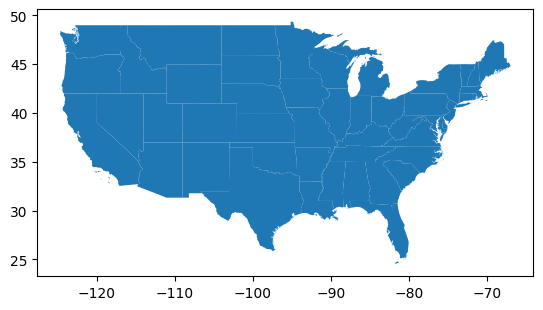

In [25]:
us49_gdf.plot()

Now it's time to merge. We need to get the readmission data aggregated at the State level to make the merging worthwile. We will also force the merge to keep only the matches from the geo dataframe (i.e. it will drop readmission data from the non-continental states)

In [34]:
readmissions_df.head()

,facility_name,facility_id,state,condition,condition_name,measure_name,number_of_discharges,readmissions_footnote,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,calc_err,calc_err_match,number_of_readmissions,readm_start_date,readm_end_date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,HIP-KNEE,Total Hip/Knee Arthroplasty,READM-30-HIP-KNEE-HRRP,NaN,NaN,1.0301,4.5819,4.4481,1.030080,1.0,NaN,7/1/18,6/30/21
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,COPD,Chronic Obstructive Pulmonary Disease,READM-30-COPD-HRRP,202.0,NaN,0.9903,19.1885,19.3765,0.990298,1.0,38.0,7/1/18,6/30/21
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,AMI,Acute Myocardial Infarction,READM-30-AMI-HRRP,319.0,NaN,0.9958,14.4888,14.5498,0.995808,1.0,46.0,7/1/18,6/30/21
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,PN,Pneumonia,READM-30-PN-HRRP,437.0,NaN,0.9568,17.0029,17.7701,0.956826,1.0,71.0,7/1/18,6/30/21
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,HF,Heart Failure,READM-30-HF-HRRP,757.0,NaN,1.0551,23.0374,21.8333,1.055150,1.0,178.0,7/1/18,6/30/21


In [84]:
state_condition_grouped_df = (
    readmissions_df.groupby(["state", "condition"])
    .agg(
        {
            "facility_id": "nunique",  # Number of unique hospitals
            "number_of_discharges": "sum",  # Total discharges
            "number_of_readmissions": "sum",  # Total readmissions
        }
    )
    .reset_index()
)

# rename columns for ease
state_condition_grouped_df = state_condition_grouped_df.rename(
    columns={
        "facility_id": "unique_hospitals",
        "number_of_discharges": "total_discharges",
        "number_of_readmissions": "total_readmissions",
    }
)

state_condition_grouped_df["readmission_rate"] = (
    state_condition_grouped_df["total_readmissions"]
    / state_condition_grouped_df["total_discharges"]
)
state_condition_grouped_df.head(15)

,state,condition,unique_hospitals,total_discharges,total_readmissions,readmission_rate
0,AK,AMI,8,639.0,80.0,0.125196
1,AK,CABG,8,0.0,0.0,NaN
2,AK,COPD,8,510.0,96.0,0.188235
3,AK,HF,8,1089.0,206.0,0.189164
4,AK,HIP-KNEE,8,805.0,35.0,0.043478
5,AK,PN,8,890.0,126.0,0.141573
6,AL,AMI,82,4785.0,726.0,0.151724
7,AL,CABG,82,1570.0,220.0,0.140127
8,AL,COPD,82,6684.0,1206.0,0.180431
9,AL,HF,82,12835.0,2700.0,0.210362


In [85]:
merged_gdf = us49_gdf.merge(
    state_condition_grouped_df, left_on="STUSPS", right_on="state"
)

merged_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state,condition,unique_hospitals,total_discharges,total_readmissions,readmission_rate
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",MS,AMI,62,3883.0,637.0,0.164048
1,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",MS,CABG,62,1256.0,148.0,0.117834
2,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",MS,COPD,62,4706.0,953.0,0.202507
3,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",MS,HF,62,10788.0,2414.0,0.223767
4,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",MS,HIP-KNEE,62,3833.0,164.0,0.042786


Text(0.5, 1.0, 'HF Readmission Rate by State')

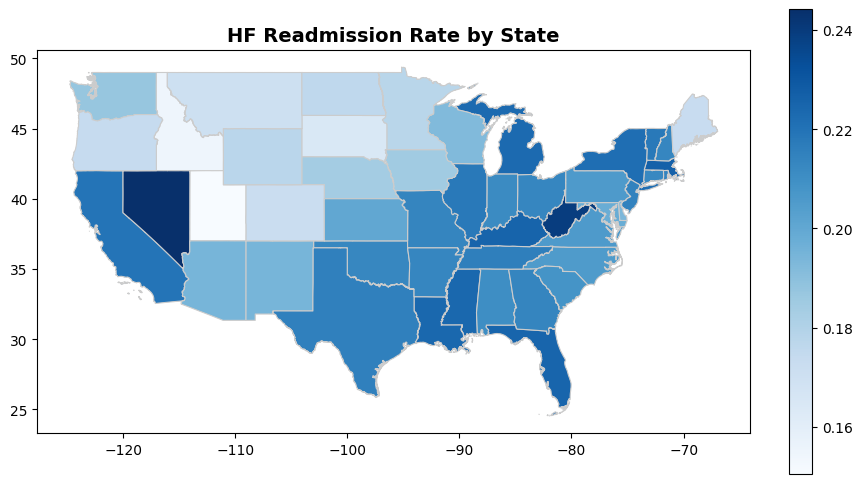

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.query("condition == 'HF'").plot(
    column="readmission_rate",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    legend_kwds={"fraction": 0.03},
)
# Customize the plot
ax.set_title(
    "HF Readmission Rate by State",
    fontdict={"fontsize": "14", "fontweight": "bold"},
)

Text(0.5, 1.0, 'PN Readmission Rate by State')

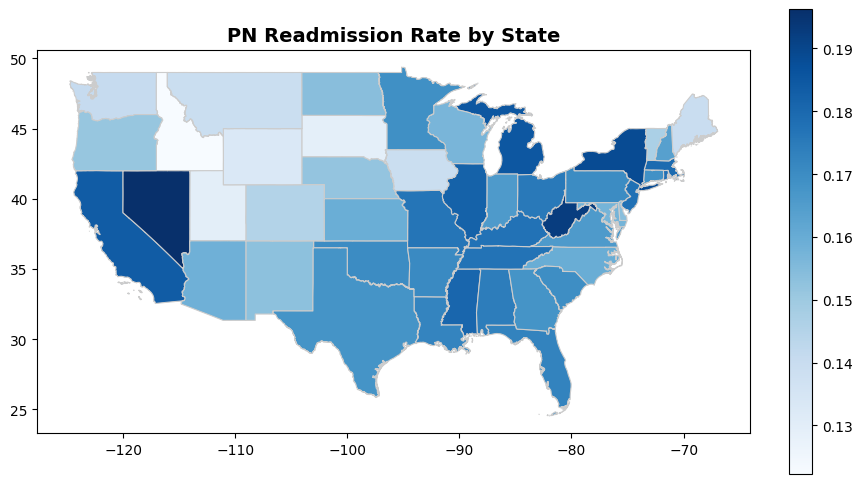

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.query("condition == 'PN'").plot(
    column="readmission_rate",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    legend_kwds={"fraction": 0.03},
)
# Customize the plot
ax.set_title(
    "PN Readmission Rate by State",
    fontdict={"fontsize": "14", "fontweight": "bold"},
)

In [88]:
valid_conditions = ["HF", "PN"]

In [89]:
state_grouped_df = (
    readmissions_df.query("condition == @valid_conditions")
    .groupby("state")
    .agg(
        {
            "facility_id": "nunique",  # Number of unique hospitals
            "number_of_discharges": "sum",  # Total discharges
            "number_of_readmissions": "sum",  # Total readmissions
        }
    )
    .reset_index()
)

# rename columns for ease
state_grouped_df = state_grouped_df.rename(
    columns={
        "facility_id": "unique_hospitals",
        "number_of_discharges": "total_discharges",
        "number_of_readmissions": "total_readmissions",
    }
)

state_grouped_df["readmission_rate"] = (
    state_grouped_df["total_readmissions"] / state_grouped_df["total_discharges"]
)

state_grouped_df.head()

,state,unique_hospitals,total_discharges,total_readmissions,readmission_rate
0,AK,8,1979.0,332.0,0.167761
1,AL,82,25736.0,4949.0,0.192299
2,AR,47,21020.0,4030.0,0.191722
3,AZ,63,27111.0,4729.0,0.174431
4,CA,282,117864.0,23753.0,0.201529


In [93]:
state_merged_gdf = us49_gdf.merge(state_grouped_df, left_on="STUSPS", right_on="state")

Text(0.5, 1.0, 'PN + HF Readmission Rate by State')

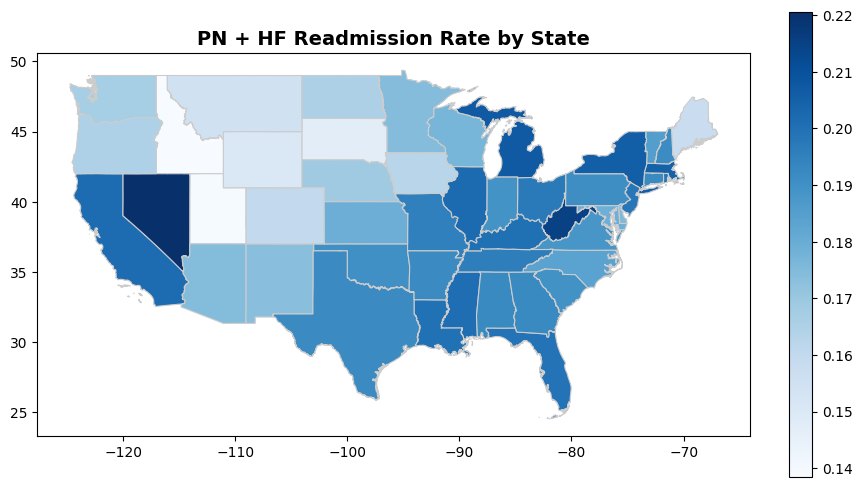

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
state_merged_gdf.plot(
    column="readmission_rate",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    legend_kwds={"fraction": 0.03},
)
# Customize the plot
ax.set_title(
    "PN + HF Readmission Rate by State",
    fontdict={"fontsize": "14", "fontweight": "bold"},
)